# NIFTY50 Portfolio Optimization Analysis

**Author:** [Krishna]
**Date:** [21st June 2025]

### Project Overview
This notebook conducts a comprehensive analysis and optimization of a stock portfolio composed of selected NIFTY50 equities. The primary objective is to construct an optimal portfolio by leveraging the Modern Portfolio Theory (MPT) framework.

The process involves:
1.  Fetching historical stock data using the `yfinance` library.
2.  Performing Exploratory Data Analysis (EDA) to understand price trends and correlations.
3.  Running a Monte Carlo simulation to generate thousands of possible portfolio weightings.
4.  Identifying the optimal portfolio based on the highest Sharpe Ratio.
5.  Analyzing the risk-return profile of the optimal portfolio, including Value at Risk (VaR).

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Style settings for plots
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Data Loading and Preparation

First, we define the list of NIFTY50 stock tickers. Then, we select a subset of these stocks for our portfolio and download their historical closing prices from Yahoo Finance.

In [2]:
nifty50_tickers = {
    'Adani Enterprises': 'ADANIENT.NS', 'Apollo Hospitals': 'APOLLOHOSP.NS', 'Asian Paints': 'ASIANPAINT.NS',
    'Axis Bank': 'AXISBANK.NS', 'Bajaj Auto': 'BAJAJ-AUTO.NS', 'Bajaj Finance': 'BAJFINANCE.NS',
    'Bajaj Finserv': 'BAJAJFINSV.NS', 'Bharti Airtel': 'BHARTIARTL.NS', 'BPCL': 'BPCL.NS',
    'Britannia': 'BRITANNIA.NS', 'Cipla': 'CIPLA.NS', 'Coal India': 'COALINDIA.NS',
    'Divi\'s Labs': 'DIVISLAB.NS', 'Dr Reddy\'s': 'DRREDDY.NS', 'Eicher Motors': 'EICHERMOT.NS',
    'Grasim': 'GRASIM.NS', 'HCL Tech': 'HCLTECH.NS', 'HDFC Bank': 'HDFCBANK.NS',
    'HDFC Life': 'HDFCLIFE.NS', 'Hero MotoCorp': 'HEROMOTOCO.NS', 'Hindalco': 'HINDALCO.NS',
    'HUL': 'HINDUNILVR.NS', 'ICICI Bank': 'ICICIBANK.NS', 'IndusInd Bank': 'INDUSINDBK.NS',
    'Infosys': 'INFY.NS', 'ITC': 'ITC.NS', 'JSW Steel': 'JSWSTEEL.NS',
    'Kotak Bank': 'KOTAKBANK.NS', 'LTIMindtree': 'LTIM.NS', 'L&T': 'LT.NS',
    'M&M': 'M&M.NS', 'Maruti Suzuki': 'MARUTI.NS', 'Nestle India': 'NESTLEIND.NS',
    'NTPC': 'NTPC.NS', 'ONGC': 'ONGC.NS', 'Power Grid': 'POWERGRID.NS',
    'Reliance': 'RELIANCE.NS', 'SBI': 'SBIN.NS', 'SBI Life': 'SBILIFE.NS',
    'Sun Pharma': 'SUNPHARMA.NS', 'Tata Consumer': 'TATACONSUM.NS', 'Tata Motors': 'TATAMOTORS.NS',
    'Tata Steel': 'TATASTEEL.NS', 'TCS': 'TCS.NS', 'Tech Mahindra': 'TECHM.NS',
    'Titan': 'TITAN.NS', 'UPL': 'UPL.NS', 'UltraTech Cement': 'ULTRACEMCO.NS', 'Wipro': 'WIPRO.NS'
}

# --- EDIT THIS LIST TO CHOOSE YOUR STOCKS ---
my_portfolio_stocks = [
    'Reliance',
    'TCS',
    'HDFC Bank',
    'Infosys',
    'ICICI Bank'
]

tickers = [nifty50_tickers[stock] for stock in my_portfolio_stocks]

# Fetch data
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')
price_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=True)['Close'].dropna()

print("Successfully loaded price data for selected stocks:")
print(price_data.tail())

[*********************100%***********************]  5 of 5 completed

Successfully loaded price data for selected stocks:
Ticker      HDFCBANK.NS  ICICIBANK.NS      INFY.NS  RELIANCE.NS       TCS.NS
Date                                                                        
2025-06-16  1935.400024   1426.900024  1623.800049  1437.800049  3496.300049
2025-06-17  1929.599976   1423.199951  1639.900024  1431.199951  3515.300049
2025-06-18  1933.900024   1412.599976  1632.900024  1430.099976  3451.399902
2025-06-19  1935.300049   1411.300049  1618.400024  1433.300049  3424.000000
2025-06-20  1964.699951   1427.099976  1622.900024  1466.199951  3435.699951


## 2. Exploratory Data Analysis (EDA)

We begin by calculating the daily returns, which are essential for measuring volatility and correlation. We then visualize the historical performance and relationships between the stocks.

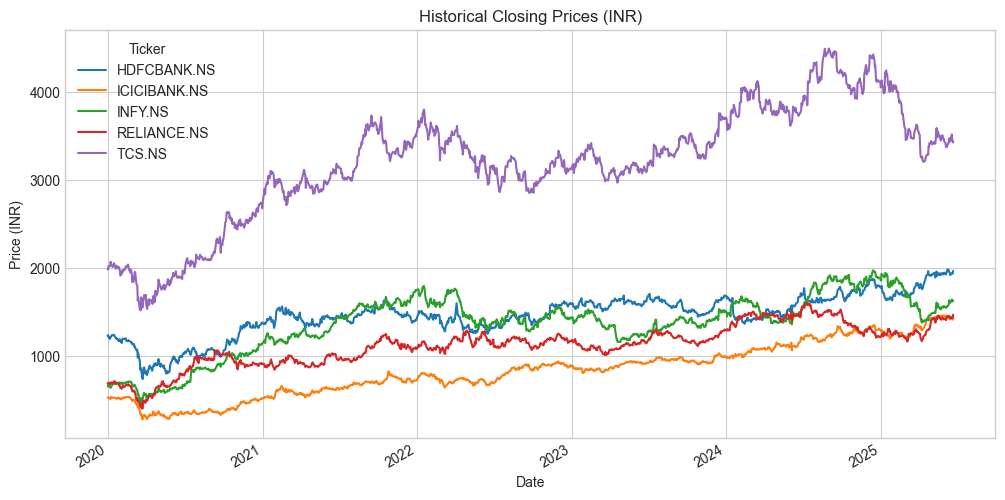

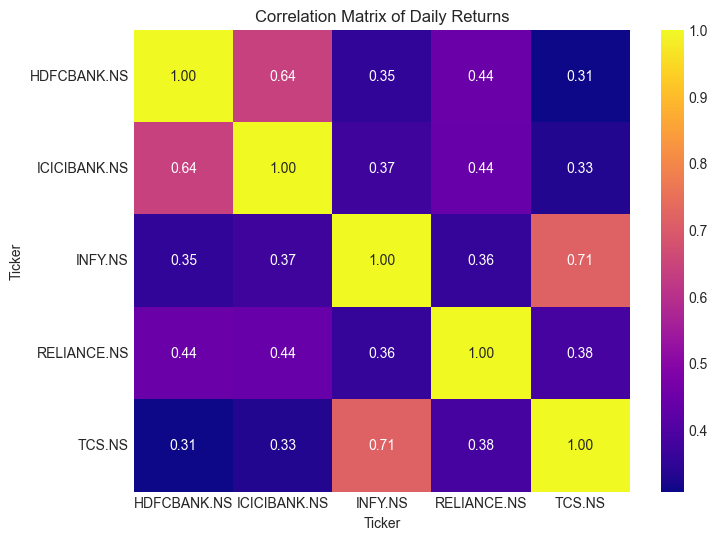

Displaying pairplot of daily returns...


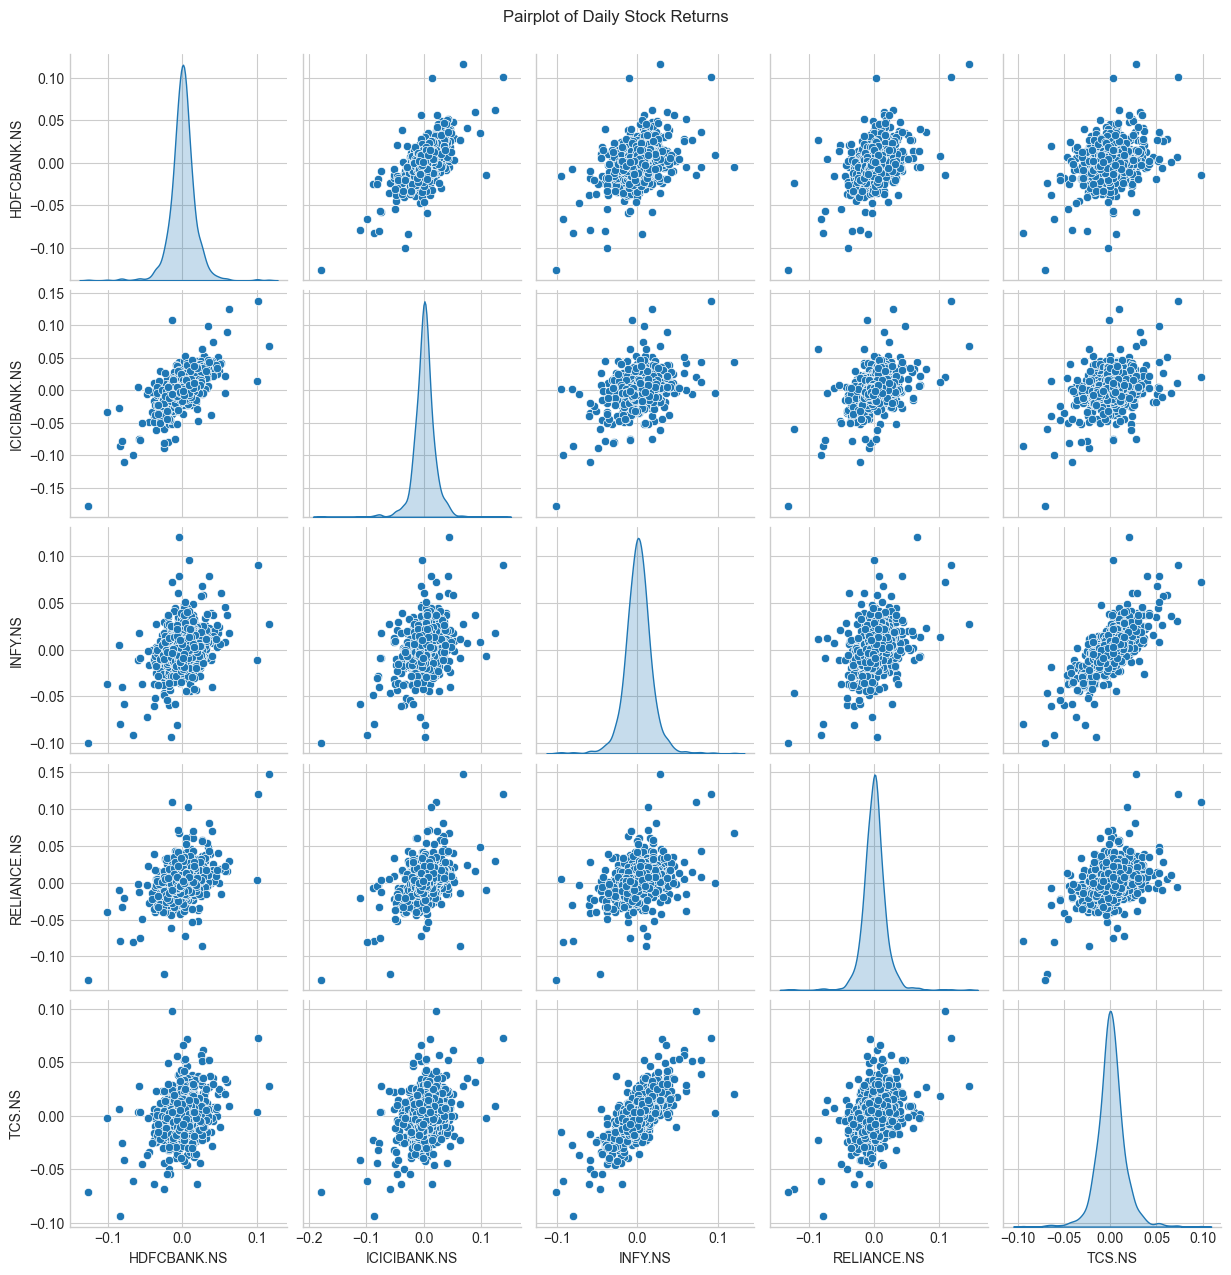

In [8]:
# Cell 6: Calculate and Visualize Daily Returns

# Calculate daily percentage returns
daily_returns = price_data.pct_change().dropna()

# Plot closing prices
price_data.plot(figsize=(12, 6), title='Historical Closing Prices (INR)')
plt.ylabel('Price (INR)')
plt.show()

# Plot correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(daily_returns.corr(), annot=True, cmap='plasma', fmt=".2f")
plt.title('Correlation Matrix of Daily Returns')
plt.show()

# --- ADDED THIS BACK IN ---
# Plot pairplot to visualize relationships and distributions
print("Displaying pairplot of daily returns...")
sns.pairplot(daily_returns, kind='scatter', diag_kind='kde')
plt.suptitle('Pairplot of Daily Stock Returns', y=1.02) # Adjust title position
plt.show()

## 3. Monte Carlo Simulation for Portfolio Optimization

Here, we simulate thousands of different portfolio weight combinations to find the one that offers the best risk-adjusted return, as measured by the Sharpe Ratio. This is the core of our optimization engine.

In [4]:
def run_monte_carlo_simulation(daily_returns, num_portfolios, risk_free_rate):
    """
    Runs a Monte Carlo simulation to find the optimal portfolio.
    """
    num_assets = len(daily_returns.columns)
    results = np.zeros((3, num_portfolios)) # 0: Return, 1: Volatility, 2: Sharpe Ratio
    weights_record = []

    mean_returns = daily_returns.mean() * 252
    cov_matrix = daily_returns.cov() * 252

    for i in range(num_portfolios):
        # Generate random weights
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)

        # Calculate portfolio metrics
        portfolio_return = np.sum(mean_returns * weights)
        portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

        # Store results
        results[0, i] = portfolio_return
        results[1, i] = portfolio_std_dev
        results[2, i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

    return results, weights_record

In [9]:
# Cell 9: Run the Simulation

# --- SET YOUR PARAMETERS HERE ---
investment_amount = float(input("💰 Enter total investment amount (in INR): "))
risk_free_rate_input = float(input("📉 Enter annual risk-free rate (e.g., for 7%, enter 7): "))
risk_free_rate = risk_free_rate_input / 100.0
num_portfolios = 20000

# Run the simulation
results, weights_record = run_monte_carlo_simulation(daily_returns, num_portfolios, risk_free_rate)

# Find the optimal portfolio (max Sharpe Ratio)
max_sharpe_idx = np.argmax(results[2])
optimal_weights = weights_record[max_sharpe_idx]
optimal_results = results[:, max_sharpe_idx]

print("\nOptimal Portfolio Found!")


Optimal Portfolio Found!


## 4. Analysis of Optimal Portfolio

After identifying the optimal portfolio, we analyze its key performance and risk metrics. We also visualize the results to clearly communicate the strategy.

--------------------------------------------------
               Optimal Portfolio Metrics          
--------------------------------------------------
Annualized Return: 21.18%
Annualized Volatility: 22.74%
Sharpe Ratio: 0.71
--------------------------------------------------

Optimal Capital Allocation:
              Allocation
Ticker                  
HDFCBANK.NS         1.20
ICICIBANK.NS       40.47
INFY.NS            33.64
RELIANCE.NS        23.44
TCS.NS              1.25


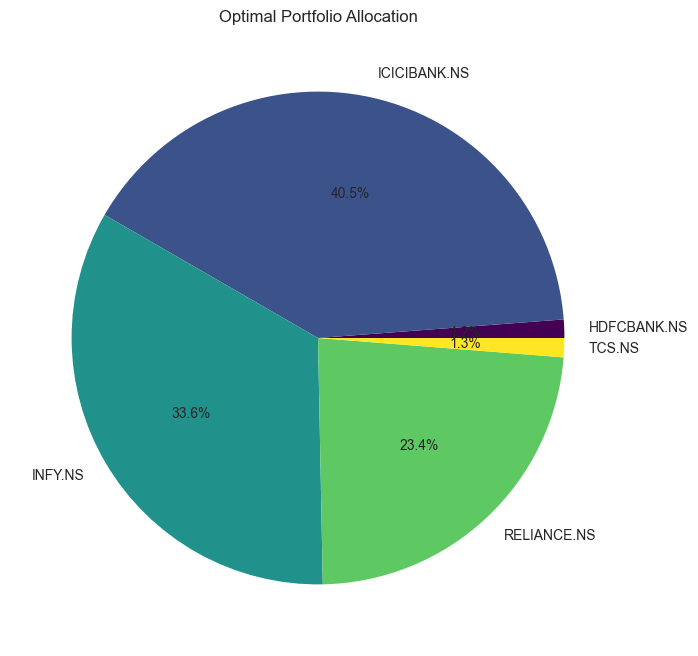

In [10]:
# Display optimal portfolio metrics
print("--------------------------------------------------")
print("               Optimal Portfolio Metrics          ")
print("--------------------------------------------------")
print(f"Annualized Return: {optimal_results[0]*100:.2f}%")
print(f"Annualized Volatility: {optimal_results[1]*100:.2f}%")
print(f"Sharpe Ratio: {optimal_results[2]:.2f}")
print("--------------------------------------------------")

# Display capital allocation
allocation_df = pd.DataFrame({'Allocation': optimal_weights * 100}, index=daily_returns.columns)
print("\nOptimal Capital Allocation:")
print(allocation_df.round(2))

# Plot allocation pie chart
allocation_df.plot.pie(y='Allocation', autopct='%1.1f%%', figsize=(8, 8), legend=False,
                       title='Optimal Portfolio Allocation', colormap='viridis')
plt.ylabel('') # Hide the 'Allocation' label on the y-axis
plt.show()

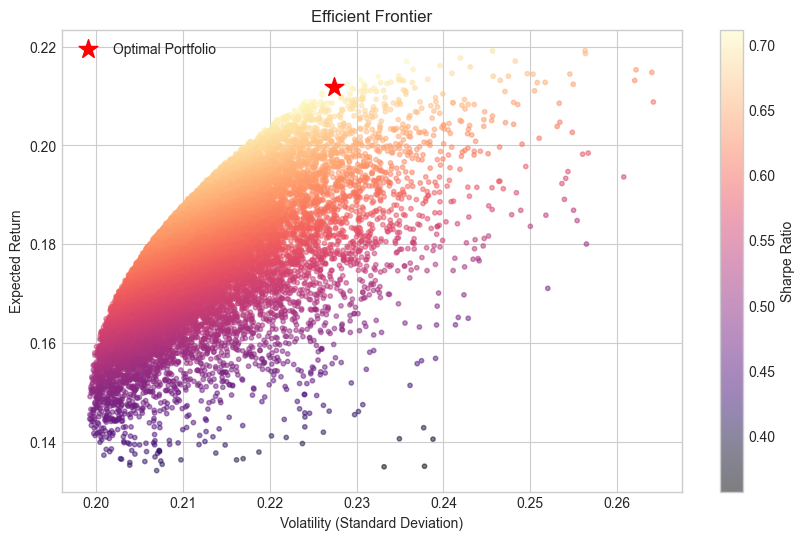

In [11]:
# Visualize all simulated portfolios (Efficient Frontier)
plt.figure(figsize=(10, 6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='magma', marker='o', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')

# Highlight the optimal portfolio
plt.scatter(optimal_results[1], optimal_results[0], color='red', marker='*', s=200, label='Optimal Portfolio')
plt.legend()
plt.show()